# Autoregressive Models
**Jin Yeom**  
jin.yeom@hudl.com

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

## 1. Warmup

First, run the following code. It will generate a dataset of samples $x \in \{1, . . . , 100\}$. Take the first 80% of the samples as a training set and the remaining 20% as a test set.

In [2]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [3]:
data = sample_data()
training_set = data[:int(len(data)*0.8)] 
test_set = data[int(len(data)*0.8):]

In [4]:
def valid_data():
    count = 2000
    rand = np.random.RandomState(23)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [5]:
validation_set = tf.constant(valid_data())

Let $\theta = (\theta_{1}, ..., \theta_{100}) \in \mathbb{R}^{100}$, and define the model

$$
p_{\theta}(x) = \frac{e^{\theta_{x}}}{\sum_{x'}{e^{\theta_{x'}}}}
$$

Fit $p_{\theta}$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

In [6]:
theta = tf.Variable(np.zeros(100), name='theta')

In [7]:
def softmax_dist(theta):
    p = tf.math.softmax(theta)
    return tfp.distributions.Categorical(probs=p)

In [8]:
def nll(model, x):
    return tf.reduce_mean(-model.log_prob(x), axis=0)

Over the course of training, record the average negative log likelihood of the training data (per minibatch) and validation data (for your entire validation set). Plot both on the same graph &ndash; the x-axis should be training setps, and the y-axis should be negative log likelihood; feel free to compute and report the validation performance less frequently. Report the test set performance of your final model. Be sure to report all negative log likelihoods in bits.

In [9]:
def minibatches(data, batch_size):
    perm = np.random.permutation(training_set)
    for i in range(0, len(training_set), batch_size):
        yield tf.constant(perm[i:i+batch_size])

In [10]:
global_iter = 0
train_losses = []
valid_losses = []
optimizer = tf.optimizers.Adam(learning_rate=1e-3)
for ep in tqdm(range(10)):
    for i, batch in enumerate(tqdm(minibatches(training_set, 16), leave=False)):
        with tf.GradientTape() as tape:
            dist = softmax_dist(theta)
            loss = nll(dist, batch)
        # record learning statistics
        train_losses.append((global_iter, loss.numpy()))
        if i % 20 == 0:
            valid_loss = nll(dist, validation_set)
            valid_losses.append((global_iter, valid_loss.numpy()))
        # update model
        grads = tape.gradient(loss, theta)
        optimizer.apply_gradients([(grads, theta)])
        global_iter += 1
dist = softmax_dist(theta)
test_loss = nll(dist, tf.constant(test_set))
print("test loss =", test_loss.numpy())


test loss = 4.049522068442216


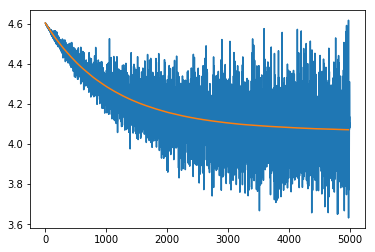

In [11]:
plt.plot(*tuple(zip(*train_losses)))
plt.plot(*tuple(zip(*valid_losses)))
plt.show()

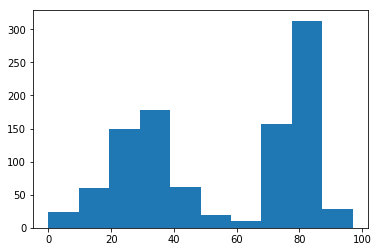

In [13]:
plt.hist([dist.sample() for i in range(1000)])
plt.show()

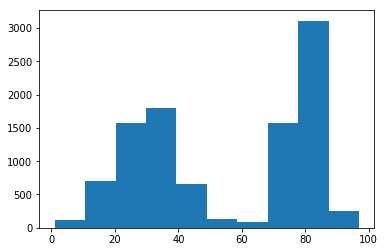

In [14]:
plt.hist(sample_data())
plt.show()